In [89]:
from pymavlink import mavutil

import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

In [90]:
path_log = 'C:/Documents/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/log_vuelo_2025/logs04'
path_res = 'C:/Documents/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/log_vuelo_2025/logs04_shp'

In [91]:
contenido = os.listdir(path_log)
len(contenido)

17

In [92]:
contenido

['2024-06-27 08-32-25.tlog',
 '2024-06-27 08-36-56.tlog',
 '2024-06-27 08-39-58.tlog',
 '2024-06-27 09-41-46.tlog',
 '2024-06-27 10-22-41.tlog',
 '2024-06-27 11-42-11.tlog',
 '2024-06-27 11-43-32.tlog',
 '2024-06-27 11-44-13.tlog',
 '2024-06-27 11-44-59.tlog',
 '2024-06-27 12-54-04.tlog',
 '2024-06-27 13-07-44.tlog',
 '2024-06-27 14-21-22.tlog',
 '2024-06-27 14-33-51.tlog',
 '2024-06-27 16-41-20.tlog',
 '2024-06-27 18-39-33.tlog',
 '2024-06-27 19-06-35.tlog',
 '2024-06-28 07-44-19.tlog']

In [93]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(i)
    #dict_lines = {'geos':list_geo, 'names':list_name}
    #gdf_line = gpd.GeoDataFrame(dict_lines, crs="EPSG:4326")
    #gdf_line_utm = gdf_line.to_crs(epsg=32720)
    return (list_geo, list_name)

In [94]:
lineas, names = leer_logs(contenido)

In [95]:
len(lineas)

17

In [96]:
len(names)

17

In [97]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'name': names, 'geometry': lineas}, crs="EPSG:4326")

In [98]:
gdf_lines

,name,geometry
0,2024-06-27 08-32-25.tlog,"LINESTRING (-62.96774 -17.29691, -62.96774 -17..."
1,2024-06-27 08-36-56.tlog,"LINESTRING (-62.96773 -17.29692, -62.96773 -17..."
2,2024-06-27 08-39-58.tlog,"LINESTRING (-62.96773 -17.29691, -62.96773 -17..."
3,2024-06-27 09-41-46.tlog,"LINESTRING (-62.96774 -17.29691, -62.96774 -17..."
4,2024-06-27 10-22-41.tlog,"LINESTRING (-62.96161 -17.29505, -62.96161 -17..."
5,2024-06-27 11-42-11.tlog,"LINESTRING (-62.96774 -17.29715, -62.96774 -17..."
6,2024-06-27 11-43-32.tlog,"LINESTRING (-63.20020 -17.23775, -63.20020 -17..."
7,2024-06-27 11-44-13.tlog,"LINESTRING (-63.20020 -17.23775, -63.20020 -17..."
8,2024-06-27 11-44-59.tlog,"LINESTRING (-63.20020 -17.23775, -63.20020 -17..."
9,2024-06-27 12-54-04.tlog,"LINESTRING (-63.20020 -17.23776, -63.20020 -17..."


In [99]:
# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [100]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['name'])

In [101]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'name': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [103]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [104]:
gdf_lines['cantidad_coordenadas'] = gdf_lines['geometry'].apply(contar_coordenadas)

In [106]:
gdf_lines

,name,geometry,cantidad_coordenadas
0,2024-06-27 08-32-25.tlog,"LINESTRING (-62.96774 -17.29691, -62.96774 -17...",26
1,2024-06-27 08-36-56.tlog,"LINESTRING (-62.96773 -17.29692, -62.96773 -17...",368
2,2024-06-27 08-39-58.tlog,"LINESTRING (-62.96773 -17.29691, -62.96773 -17...",467
3,2024-06-27 09-41-46.tlog,"LINESTRING (-62.96774 -17.29691, -62.96774 -17...",1686
4,2024-06-27 10-22-41.tlog,"LINESTRING (-62.96161 -17.29505, -62.96161 -17...",2840
5,2024-06-27 11-42-11.tlog,"LINESTRING (-62.96774 -17.29715, -62.96774 -17...",1305
6,2024-06-27 11-43-32.tlog,"LINESTRING (-63.20020 -17.23775, -63.20020 -17...",173
7,2024-06-27 11-44-13.tlog,"LINESTRING (-63.20020 -17.23775, -63.20020 -17...",14
8,2024-06-27 11-44-59.tlog,"LINESTRING (-63.20020 -17.23775, -63.20020 -17...",63
9,2024-06-27 12-54-04.tlog,"LINESTRING (-63.20020 -17.23776, -63.20020 -17...",3451


<Axes: >

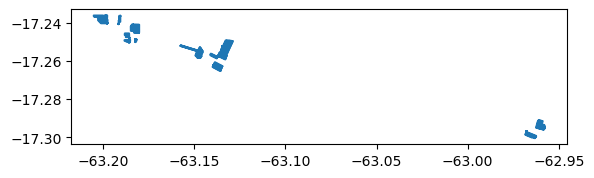

In [107]:
gdf_lines.plot()

In [108]:
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

In [109]:
output_path = 'output_lines_with_names_shapefile.shp'
gdf_lines_utm.to_file(output_path)

C:\Users\bismarksr\AppData\Local\Temp\ipykernel_22500\1545180309.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_lines_utm.to_file(output_path)
